# Eval code

In [1]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def load_baseline_df(event_path, filter_prefix=None):
    # Load the TensorBoard event file
    event_acc = EventAccumulator(event_path)
    event_acc.Reload()

    # Get list of available tags/metrics
    tags = event_acc.Tags()

    # Create dictionary to store metrics
    metrics = {}

    # Extract metrics into dictionary
    for tag in tags['scalars']:
        if filter_prefix and not tag.startswith(filter_prefix):
            continue
        events = event_acc.Scalars(tag)
        metrics[tag] = pd.DataFrame(events)[['step', 'value']]
        metrics[tag] = metrics[tag].set_index('step')
        metrics[tag].columns = [tag]

    # Combine all metrics into single dataframe by joining on step index
    df = pd.DataFrame()
    for metric_df in metrics.values():
        df = df.join(metric_df, how='outer')

    return df

In [2]:
baseline_df = load_baseline_df(r"runs\ALE\SpaceInvaders-v5__random_baseline__1__20241222_144155\events.out.tfevents.1734874915.DESKTOP-O5Q6R7F.18300.0", filter_prefix="eval/")
print(f"baseline_df.shape: {baseline_df.shape}")
baseline_df.head()

baseline_df.shape: (100, 3)


,eval/episodic_return,eval/episodic_length,eval/episodic_time
step,,,
0,130.0,500.0,0.425554
1,90.0,686.0,0.563621
2,40.0,486.0,0.338183
3,30.0,298.0,0.196890
4,50.0,370.0,0.252355


In [3]:
initial_df = load_baseline_df(r"runs\ALE\SpaceInvaders-v5__ppo_clean_rl__1__20241222_122947\events.out.tfevents.1734866993.DESKTOP-O5Q6R7F.20524.0", filter_prefix="eval/")
initial_df.head()

,eval/episodic_return,eval/episodic_length,eval/episodic_time
step,,,
0,425.0,813.0,1.119566
1,240.0,524.0,0.712688
2,270.0,685.0,0.851845
3,530.0,976.0,1.124787
4,545.0,1065.0,1.204702


In [4]:
def plot_episode_stats_boxplots(df):
    """
    Create box plots showing the distribution of episode returns, lengths and times.
    
    Args:
        df: DataFrame containing columns 'eval/episodic_return', 'eval/episodic_length', 'eval/episodic_time'
    """
    # Create figure with subplots
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Calculate statistics for each metric
    returns = df['eval/episodic_return'].dropna()
    lengths = df['eval/episodic_length'].dropna() 
    times = df['eval/episodic_time'].dropna()

    # Create box plots for each metric
    sns.boxplot(y=returns, ax=axes[0])
    axes[0].set_title(f'Episode Returns\nMean: {returns.mean():.1f}, Std: {returns.std():.1f}')
    axes[0].set_ylabel('Return')

    sns.boxplot(y=lengths, ax=axes[1])
    axes[1].set_title(f'Episode Lengths\nMean: {lengths.mean():.1f}, Std: {lengths.std():.1f}')
    axes[1].set_ylabel('Length')

    sns.boxplot(y=times, ax=axes[2])
    axes[2].set_title(f'Episode Times\nMean: {times.mean():.3f}, Std: {times.std():.3f}')
    axes[2].set_ylabel('Time (s)')

    plt.tight_layout()
    plt.show()

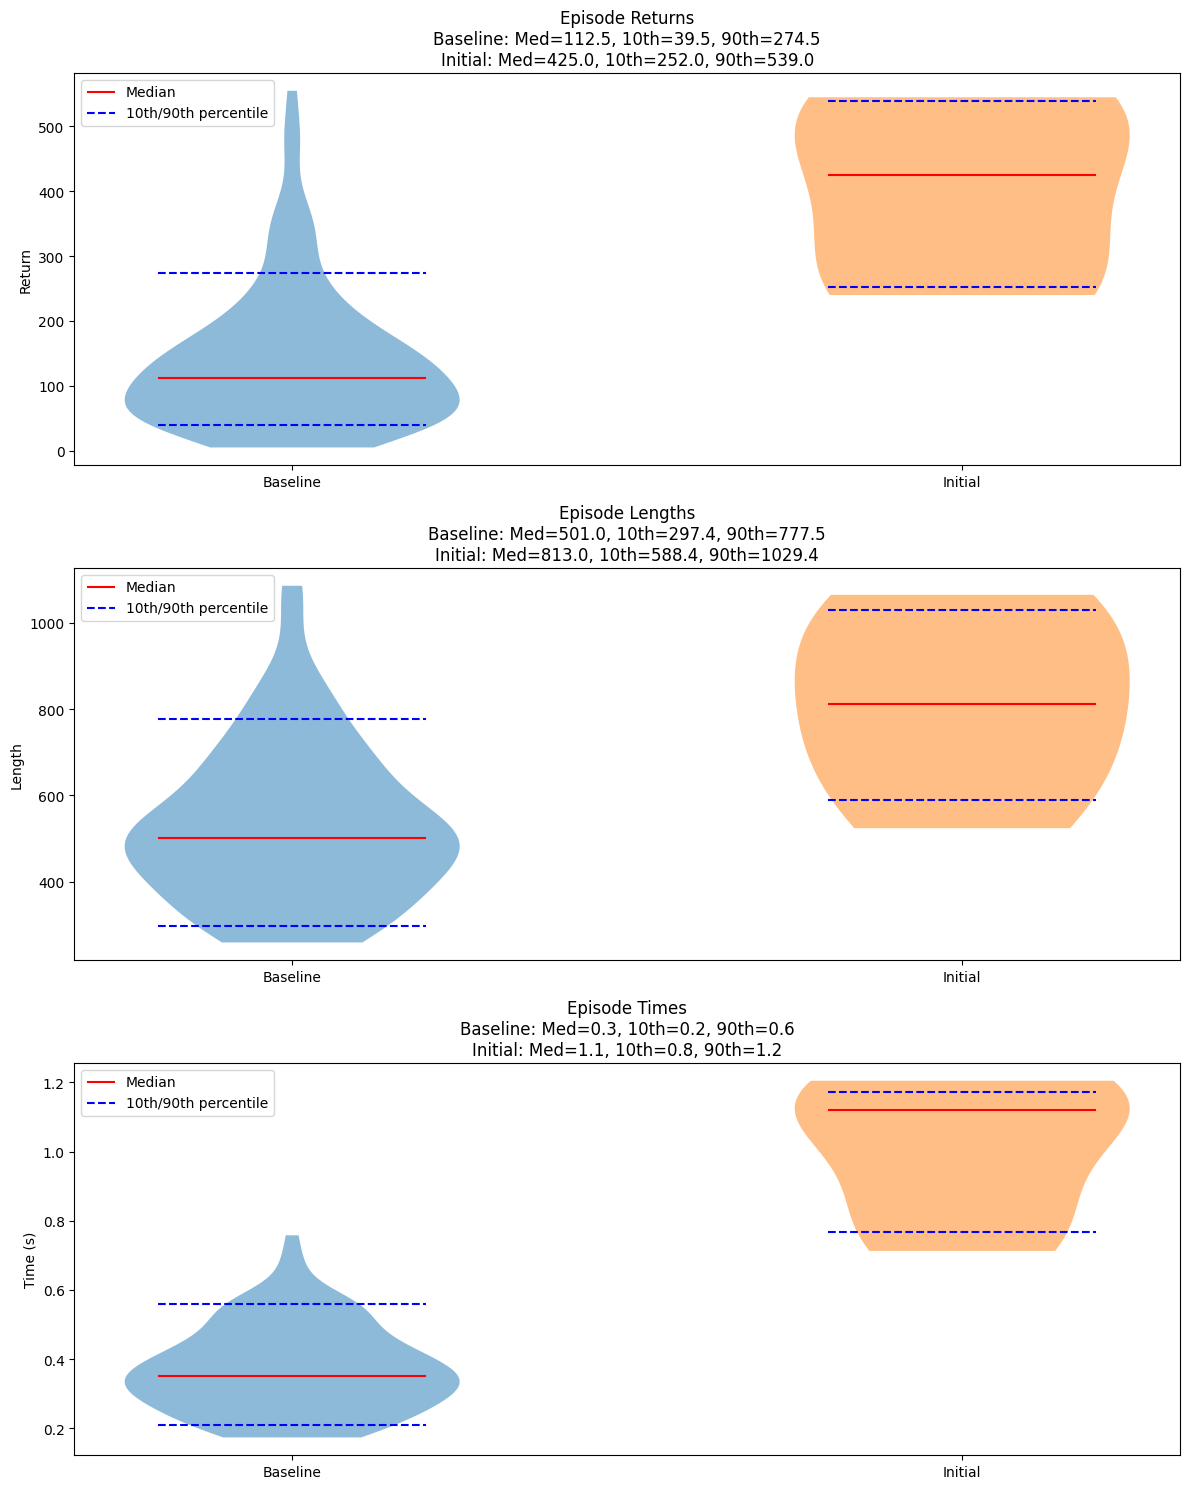

In [5]:
def plot_episode_stats_violin(*dfs, labels=None):
    """
    Create violin plots showing the distribution of episode returns, lengths and times,
    with median and 10th/90th percentile lines. Plots multiple dataframes side by side.
    
    Args:
        *dfs: Variable number of DataFrames containing columns 'eval/episodic_return', 
              'eval/episodic_length', 'eval/episodic_time'
        labels: Optional list of labels for each DataFrame
    """
    if labels is None:
        labels = [f'Dataset {i+1}' for i in range(len(dfs))]
        
    # Create figure with stacked subplots
    fig, axes = plt.subplots(3, 1, figsize=(12, 15))
    
    metrics = ['eval/episodic_return', 'eval/episodic_length', 'eval/episodic_time']
    titles = ['Episode Returns', 'Episode Lengths', 'Episode Times']
    ylabels = ['Return', 'Length', 'Time (s)']
    
    # Define colors for each violin
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

    for i, (metric, title, ylabel) in enumerate(zip(metrics, titles, ylabels)):
        for j, df in enumerate(dfs):
            data = df[metric].dropna()
            
            # Calculate statistics
            median = np.median(data)
            p10 = np.percentile(data, 10)
            p90 = np.percentile(data, 90)
            
            # Position for this violin
            pos = j + 1
            
            # Create violin plot with clipped ends
            parts = axes[i].violinplot(data, positions=[pos], showmedians=False, showextrema=False)
            
            # Customize violin appearance
            for pc in parts['bodies']:
                pc.set_facecolor(colors[j % len(colors)])
                pc.set_alpha(0.5)
            
            # Add lines for median and percentiles
            axes[i].hlines(median, pos-0.2, pos+0.2, color='red', linestyle='-', label='Median' if j==0 else "")
            axes[i].hlines(p10, pos-0.2, pos+0.2, color='blue', linestyle='--', label='10th/90th percentile' if j==0 else "")
            axes[i].hlines(p90, pos-0.2, pos+0.2, color='blue', linestyle='--')
            
        # Customize plot
        axes[i].set_xticks(range(1, len(dfs) + 1))
        axes[i].set_xticklabels(labels)
        
        # Add statistics to title
        stats_text = []
        for j, df in enumerate(dfs):
            data = df[metric].dropna()
            median = np.median(data)
            p10 = np.percentile(data, 10)
            p90 = np.percentile(data, 90)
            stats_text.append(f'{labels[j]}: Med={median:.1f}, 10th={p10:.1f}, 90th={p90:.1f}')
        
        axes[i].set_title(f"{title}\n" + "\n".join(stats_text))
        axes[i].set_ylabel(ylabel)
        axes[i].legend()

    plt.tight_layout()
    plt.show()

# Example usage with two dataframes:
plot_episode_stats_violin(baseline_df, initial_df, labels=['Baseline', 'Initial'])

In [6]:
def print_metric_ranges(df):
    """
    Print the minimum and maximum values for each metric in the dataframe.
    
    Args:
        df: DataFrame containing metrics to analyze
    """
    for col in df.columns:
        print(f"\n{col}:")
        print(f"Min: {df[col].min():.1f}")
        print(f"Max: {df[col].max():.1f}")

print_metric_ranges(initial_df)



eval/episodic_return:
Min: 240.0
Max: 545.0

eval/episodic_length:
Min: 524.0
Max: 1065.0

eval/episodic_time:
Min: 0.7
Max: 1.2


# Train

In [64]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import pandas as pd

def load_tensorboard_data(event_path):
    """
    Load training metrics from a TensorBoard event file into a pandas DataFrame
    
    Args:
        event_path (str): Path to the TensorBoard events file
        
    Returns:
        pd.DataFrame: DataFrame containing training metrics with columns:
            - train/episodic_return
            - train/episodic_length 
            - train/episodic_time
    """
    # Load the TensorBoard event file
    event_acc = EventAccumulator(event_path)
    event_acc.Reload()

    # Get list of available tags/metrics
    tags = event_acc.Tags()

    # Create dictionary to store metrics
    metrics = {}

    # Extract metrics into dictionary
    for tag in tags['scalars']:
        events = event_acc.Scalars(tag)
        metrics[tag] = pd.DataFrame(events)[['step', 'value']]
        metrics[tag] = metrics[tag].set_index('step')
        metrics[tag].columns = [tag]

    # Combine all metrics into single dataframe by joining on step index
    df = pd.DataFrame()
    for metric_df in metrics.values():
        df = df.join(metric_df, how='outer')

    # Rename training metrics to have train/ prefix
    rename_map = {
        'charts/episodic_return': 'train/episodic_return',
        'charts/episodic_length': 'train/episodic_length', 
        'charts/episodic_time': 'train/episodic_time'
    }

    df = df.rename(columns=rename_map)

    # Select only training metrics
    cols = ['train/episodic_return', 'train/episodic_length', 'train/episodic_time']
    df = df[cols]
    
    df = df.dropna()

    return df


df_initial_train = load_tensorboard_data(r"slurm\ALE\SpaceInvaders-v5__initial_run__1__20241222_223225\events.out.tfevents.1734903150.server0103.3030611.0")
df_epsilon_0_2_train = load_tensorboard_data(r"slurm\ALE\SpaceInvaders-v5__epsilon_tuning_0.2__1__20241223_003839\events.out.tfevents.1734910725.server0103.3060251.0")
df_epsilon_0_3_train = load_tensorboard_data(r"slurm\ALE\SpaceInvaders-v5__epsilon_tuning_0.3__1__20241223_011006\events.out.tfevents.1734912622.server0103.3067890.0")
df_epsilon_0_4_train = load_tensorboard_data(r"slurm\ALE\SpaceInvaders-v5__epsilon_tuning_0.4__1__20241223_014124\events.out.tfevents.1734914490.server0103.3075611.0")
print(f"df.shape: {df_initial_train.shape}")
df_initial_train.head(10)

df.shape: (6647, 3)


,train/episodic_return,train/episodic_length,train/episodic_time
step,,,
816,50.0,255.0,2.396105
1040,60.0,287.0,2.996984
1072,110.0,291.0,3.450502
1120,70.0,327.0,3.642527
1392,45.0,389.0,2.877860
1760,110.0,468.0,3.831110
1808,80.0,504.0,4.708944
1840,140.0,511.0,3.901869
1888,200.0,513.0,5.158602


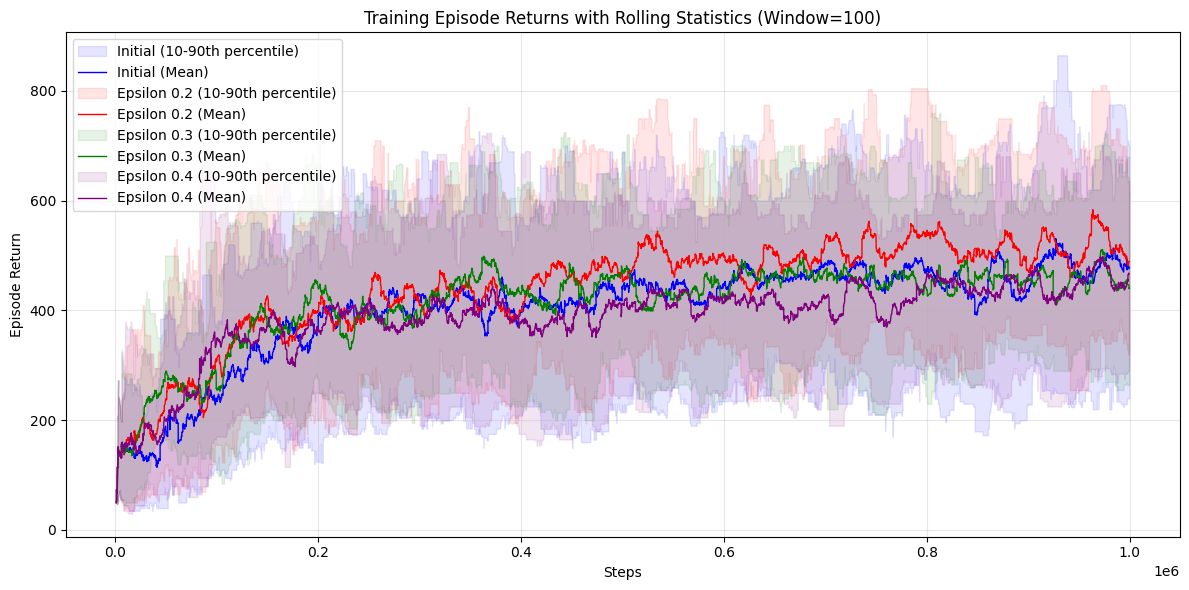

In [67]:
def plot_episode_lengths(dataframes, labels, colors, window=100):
    """
    Plot episode returns with rolling statistics for multiple dataframes
    
    Args:
        dataframes: List of dataframes containing 'train/episodic_return' column
        labels: List of labels for each dataframe
        colors: List of colors for each dataframe
        window: Window size for rolling statistics
    """
    plt.figure(figsize=(12,6))

    for df, label, color in zip(dataframes, labels, colors):
        # Calculate rolling statistics
        rolling_mean = df['train/episodic_return'].rolling(window=window, min_periods=1).mean()
        rolling_10th = df['train/episodic_return'].rolling(window=window, min_periods=1).quantile(0.1)
        rolling_90th = df['train/episodic_return'].rolling(window=window, min_periods=1).quantile(0.9)

        # Plot shaded area between 10th and 90th percentiles
        plt.fill_between(df.index, rolling_10th, rolling_90th, alpha=0.1, color=color, 
                        label=f'{label} (10-90th percentile)')
        
        # Plot mean line
        plt.plot(df.index, rolling_mean, color=color, linestyle='-', 
                label=f'{label} (Mean)', linewidth=1)

    plt.title('Training Episode Returns with Rolling Statistics (Window=100)')
    plt.xlabel('Steps') 
    plt.ylabel('Episode Return')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Example usage:
plot_episode_lengths(
    [df_initial_train, df_epsilon_0_2_train, df_epsilon_0_3_train, df_epsilon_0_4_train],
    ['Initial', 'Epsilon 0.2', 'Epsilon 0.3', 'Epsilon 0.4'],
    ['blue', 'red', 'green', 'purple'])